<a href="https://colab.research.google.com/github/rahulzach/FFT/blob/main/Speaker_Identification_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import tensorflow as tf
import os
from os.path import isfile, join
import numpy as np
import shutil
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import subprocess
from tensorflow.keras.layers import Conv1D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [ ]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'speaker-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F470244%2F881667%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T170642Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5726f82e0d9666a57598257ea7db777f479ca136bbea25424b365edc397adb06d2576b7afb9d2a5ef8ecacf289dcd23c914bed457b0961bc34af55f27ac22b8bd8157fdd727d5b5d751e6d04880053d2c59e15817af360dbd9babde179e1d15b7b6c6034ec5ab30594d2cec49a6f6d5d90d992e8bdc4d772a0e6561eaa4788914d60a5162bfc5f86c98c398069ebbf8d1ee5c8f1ec47c047c2f78cd8a0ca0e6a73cc7c8ee0cf541faa355306f939312399af63ea14f7ea6c40d45397ad2ac9bef1664cae8a97eb172ee569c3132861e3f639edb463e835ef8cbcfb11d0e7766b64c274c61c8579c2ab3803863d0117addea246b86ff87ed71753df3a36cef4ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:h
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 241803761 bytes downloaded
Downloaded and uncompressed: speaker-recognition-dataset
Data source import complete.


In [ ]:
!cp -r "../input/speaker-recognition-dataset" ./

In [ ]:
data_directory = "./speaker-recognition-dataset/16000_pcm_speeches"
audio_folder = "audio"
noise_folder = "noise"

audio_path = os.path.join(data_directory, audio_folder)
noise_path = os.path.join(data_directory, noise_folder)

In [ ]:
audio_path

'./speaker-recognition-dataset/16000_pcm_speeches/audio'

In [ ]:
valid_split = 0.1
shuffle_seed = 43
sample_rate = 16000
scale = 0.5
batch_size = 128
epochs = 15

In [ ]:
for folder in os.listdir(data_directory):
    if os.path.isdir(os.path.join(data_directory, folder)):
        if folder in [audio_folder, noise_folder]:

            continue
        elif folder in ["other", "_background_noise_"]:

            shutil.move(
                os.path.join(data_directory, folder),
                os.path.join(noise_path, folder),
            )
        else:
            shutil.move(
                os.path.join(data_directory, folder),
                os.path.join(audio_path, folder),
            )

In [ ]:
noise_paths = []
for subdir in os.listdir(noise_path):
    subdir_path = Path(noise_path) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

In [ ]:
noise_paths

['speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/running_tap.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/doing_the_dishes.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/dude_miaowing.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/other/exercise_bike.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/other/pink_noise.wav']

In [ ]:
command = (
    "for dir in `ls -1 " + noise_path + "`; do "
    "for file in `ls -1 " + noise_path + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

In [ ]:
os.system(command)
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == sample_rate:
        slices = int(sample.shape[0] / sample_rate)
        sample = tf.split(sample[: slices * sample_rate], slices)
        return sample
    else:
        print("Sampling rate for",path, "is incorrect")
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

In [ ]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [ ]:
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, sample_rate)
    return audio

In [ ]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio

In [ ]:
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [ ]:
class_names = os.listdir(audio_path)
print(class_names,)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Speaker:",(name))
    dir_path = Path(audio_path) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

['Benjamin_Netanyau', 'Nelson_Mandela', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher']
Speaker: Benjamin_Netanyau
Speaker: Nelson_Mandela
Speaker: Jens_Stoltenberg
Speaker: Julia_Gillard
Speaker: Magaret_Tarcher


In [ ]:
# Shuffle to generate random data
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(audio_paths)
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(labels)

In [ ]:
# Split into training and validation
num_val_samples = int(valid_split * len(audio_paths))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]


valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

In [ ]:
# Create datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=shuffle_seed).batch(32)

In [ ]:
# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=scale), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def residual_block(x, filters, conv_num = 3, activation = "relu"):
    s = keras.layers.Conv1D(filters, 1, padding = "same")(x)

    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
        x = keras.layers.Activation(activation)(x)

    x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)

    return keras.layers.MaxPool1D(pool_size = 2, strides = 2)(x)

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape = input_shape, name = "input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(inputs, 32, 2)
    x = residual_block(inputs, 64, 3)
    x = residual_block(inputs, 128, 3)
    x = residual_block(inputs, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation = "softmax", name = "output")(x)

    return keras.models.Model(inputs = inputs, outputs = outputs)

model = build_model((sample_rate // 2, 1), len(class_names))

model.summary()

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_15 (Conv1D)          (None, 8000, 128)            512       ['input[0][0]']               
                                                                                                  
 activation_10 (Activation)  (None, 8000, 128)            0         ['conv1d_15[0][0]']           
                                                                                                  
 conv1d_16 (Conv1D)          (None, 8000, 128)            49280     ['activation_10[0][0]']       
                                                                                              

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/15
53/53 [==============================] - ETA: 0s - loss: 17.9802 - accuracy: 0.5501

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 36s 524ms/step - loss: 17.9802 - accuracy: 0.5501 - val_loss: 0.4457 - val_accuracy: 0.8653
Epoch 2/15
53/53 [==============================] - 25s 468ms/step - loss: 0.2614 - accuracy: 0.9107 - val_loss: 0.1692 - val_accuracy: 0.9333
Epoch 3/15
53/53 [==============================] - 27s 505ms/step - loss: 0.1346 - accuracy: 0.9492 - val_loss: 0.1321 - val_accuracy: 0.9547
Epoch 4/15
53/53 [==============================] - 27s 500ms/step - loss: 0.1005 - accuracy: 0.9639 - val_loss: 0.0699 - val_accuracy: 0.9787
Epoch 5/15
53/53 [==============================] - 21s 385ms/step - loss: 0.0835 - accuracy: 0.9699 - val_loss: 0.0728 - val_accuracy: 0.9787
Epoch 6/15
53/53 [==============================] - 27s 499ms/step - loss: 0.0662 - accuracy: 0.9748 - val_loss: 0.0603 - val_accuracy: 0.9813
Epoch 7/15
53/53 [==============================] - 25s 472ms/step - loss: 0.0901 - accuracy: 0.9658 - val_loss: 0.0553 - val_accuracy: 0.9867
Epoch 8/1

In [ ]:
print("Accuracy of model:",model.evaluate(valid_ds))

24/24 [==============================] - 1s 38ms/step - loss: 0.0354 - accuracy: 0.9907
Accuracy of model: [0.035441067069768906, 0.9906666874885559]


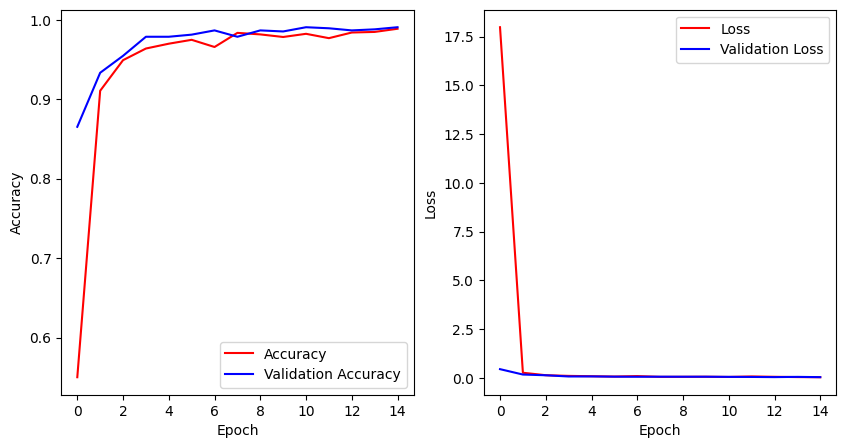

In [ ]:

import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy and validation accuracy on the first subplot
ax1.plot(acc, color='red', label='Accuracy')
ax1.plot(val_acc, color='blue', label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the loss and validation loss on the second subplot
ax2.plot(loss, color='red', label='Loss')
ax2.plot(val_loss, color='blue', label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the figure
plt.show()


24/24 [==============================] - 1s 36ms/step
[[32 22 35 39 27]
 [31 28 27 29 26]
 [20 34 36 26 36]
 [38 27 32 22 28]
 [34 30 23 32 36]]



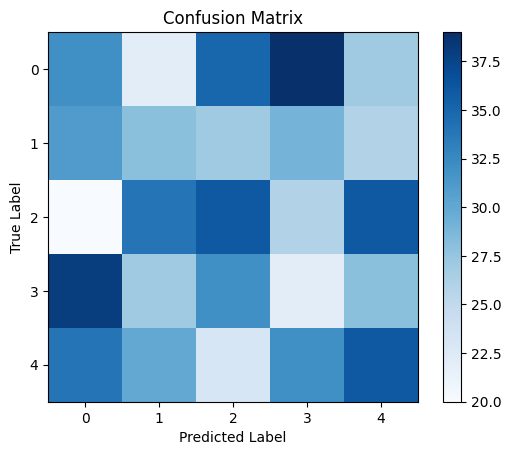

In [ ]:
y_pred = model.predict(valid_ds)

# Get the true labels
y_true = np.array(valid_labels)

# Generate confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Print the confusion matrix
print(cm)
print("")
# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
 def paths_to_dataset(audio_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
    test = paths_and_labels_to_dataset(path, labels)


    test = test.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
    )
    test = test.prefetch(tf.data.experimental.AUTOTUNE)


    test = test.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

    for audios, labels in test.take(1):
        ffts = audio_to_fft(audios)
        y_pred = model.predict(ffts)
        rnd = np.random.randint(0, 1, 1)
        audios = audios.numpy()[rnd, :]
        labels = labels.numpy()[rnd]
        y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(1):
            print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
            "[92m",y_pred[index],
                "[92m", y_pred[index]
                )
            )

            print("Speaker Predicted:",class_names[y_pred[index]])

In [ ]:
path = ["../input/speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/1013.wav"]
labels = ["unknown"]
try:
    predict(path, labels)
except:
    print("Error! Check if the file correctly passed or not!")

1/1 [==============================] - 0s 348ms/step
Speaker: 2	Predicted: 2
Speaker Predicted: Jens_Stoltenberg
